In [2]:
from scipy import stats
import numpy as np

import pandas as pd
from pandas import DataFrame
pd.options.display.max_columns = 500
pd.options.display.max_rows = 100

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import cm
%matplotlib inline
# import smplotlib

import read_mist_models
import mesa_reader as mr

import astropy.units as u
import astropy.coordinates as coord
from astropy.table import Table

from astroquery.gaia import Gaia
from astroquery.simbad import Simbad
from astroquery.vizier import Vizier
import astroquery.gaia
Vizier.ROW_LIMIT=-1
vsearch = Vizier(columns=["+_r","**"])#,column_filters={'Gmag': '<11'}
import astroquery.gaia
import glob, itertools

import logging
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['text.usetex'] = True

In [3]:
def apparent_to_absolute(apparent_mag, parallax):
    '''
    apparent_mag: apparent magnitude of the target
    parallax: parallax of the target in milliarcseconds (mas)
    '''

    parallax_as = parallax / 1000
    distance = 1 / parallax_as # distance in pc (assuming small angle approximation is valid)
    absolute_mag = apparent_mag - 5 * np.log10(distance) + 5

    return absolute_mag

def circular_bounds(color, gmag, target_color, target_gmag, r):
    indices = np.argwhere((color < (np.sqrt(r**2 - (gmag - target_gmag)**2) + target_color)) and (gmag < (np.sqrt(r**2 - (color - target_color)**2) + target_gmag)))
    return indices
                          

def grab_target_gaia_data(targetid, teff=None, logg=None, AG=None, E_BPRP=None, feh=None):
    '''
    targetid: The target's TOI number or TIC ID, to be used to query Gaia. E.g. 'TOI-3129' or 'TIC 4711'
    teff: The target's effective temperature in Kelvin.
    logg: The target's logg in cgs units.
    AG: The target's extinction in the Gaia G bandpass
    E_BPRP: The target's extinction in Gaia BP - RP color
    feh: The target's [Fe/H] in dex.
    '''

    # if method=='from_file':
    #     target_df = pd.read_csv(file, sep='\s+')

    #     for i in target_df.index:
    #         target_df['Gmag_absolute'][i]=apparent_to_absolute(target_df.Gmag[i] - AG, target_df.Plx[i])
    #         target_df['bp_rp_corr'][i]=target_df['BP-RP'][i]-E_BPRP
    # elif method=='astroquery':
    if targetid[:3]=='TOI':
        url="https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=pipe"
        TOI_df=pd.read_csv(url, delimiter='|', index_col=1)
        TOI_id = targetid.replace('TOI-','') + '.01'
        ticid = 'TIC ' + str(TOI_df.loc[float(TOI_id)]['TIC ID'])
    elif targetid[:3]=='TIC':
        ticid=targetid

    columns = ['Source', 'Gmag', 'e_Gmag', 'BPmag', 'e_BPmag', 'RPmag', 'e_RPmag', 'Plx', 'e_Plx', 'RUWE', 'BP-RP', 'Teff', 'logg', 'vbroad', 'AG', 'E(BP-RP)', '[Fe/H]']
    # columns = ['all']
    Vizier_search = Vizier(columns=columns)
    result = Vizier_search.query_object(ticid, catalog='I/355/gaiadr3', radius=2 * u.arcsec)[0]
    target_df = result.to_pandas()

    # initializing computed columns
    target_df['Gmag_absolute'] = [np.nan] * len(target_df)
    target_df['bp_rp_corr'] = [np.nan] * len(target_df)

    for i in target_df.index:
        if np.isnan(target_df['AG'][i]):
            target_df['AG'][i] = AG
            if np.isnan(target_df['AG'][i]):
                logging.warning('No extinction provided or found. Setting A(G) extinction equal to zero.')
                target_df['AG'][i] = 0
        if np.isnan(target_df['E_BP-RP_'][i]):
            target_df['E_BP-RP_'][i] = E_BPRP
            if np.isnan(target_df['E_BP-RP_'][i]):
                logging.warning('No extinction provided or found. Setting E(BP-RP) extinction equal to zero.')
                target_df['E_BP-RP_'][i] = 0
        target_df['Gmag_absolute'][i]=apparent_to_absolute(target_df.Gmag[i] - target_df['AG'], target_df.Plx[i])
        target_df['bp_rp_corr'][i]=target_df['BP-RP'][i]-target_df['E_BP-RP_']

        # Set logg and teff to user input if provided
        if logg != None:
            target_df['logg'][i]=logg
        if teff != None:
            target_df['Teff'][i]=teff
        if feh != None:
            target_df['__Fe_H_'][i] = feh

        # collect the Teff and logg from user input if not provided
        if np.isnan(target_df['Teff'][i]):
            if targetid[:3]=='TOI':
                target_df['Teff'][i] = TOI_df.loc[float(TOI_id)]['Stellar Eff Temp (K)']
            else:
                target_df['Teff'][i] = float(input('No teff provided or found. Please enter it here.\n'))
        if np.isnan(target_df['logg'][i]):
            if targetid[:3]=='TOI':
                target_df['logg'][i] = TOI_df.loc[float(TOI_id)]['Stellar log(g) (cm/s^2)']
            else:
                target_df['logg'][i] = float(input('No logg provided or found. Please enter it here.\n'))

        if np.isnan(target_df['__Fe_H_'][i]):
            target_df['__Fe_H_'][i] = float(input('No [Fe/H] provided or found. Please enter it here.\n'))

    return target_df

def query_and_cut_gaia(color_limits, gmag_limits, target_df=None):

    if color_limits == 'default':
        color_limits = (float(target_df.bp_rp_corr - 0.05), float(target_df.bp_rp_corr + 0.05))
    if gmag_limits == 'default':
        gmag_limits = (float(target_df.Gmag_absolute - 0.08), float(target_df.Gmag_absolute + 0.08))

    # My query
    # query=f'''SELECT TOP 50000 
    # gaia_source.source_id,
    # gaia_source.ra,
    # gaia_source.dec,
    # gaia_source.phot_g_mean_mag,
    # gaia_source.bp_rp,
    # gaia_source.ag_gspphot,
    # gaia_source.ebpminrp_gspphot,
    # ebpminrp_gspphot_upper,
    # ebpminrp_gspphot_lower,
    # gaia_source.distance_gspphot,
    # gaia_source.parallax,
    # gaia_source.ag_gspphot_upper,
    # gaia_source.ag_gspphot_lower,
    # gaia_source.ruwe
    # FROM gaiadr3.gaia_source 
    # WHERE (gaiadr3.gaia_source.logg_gspphot<5
    # AND gaiadr3.gaia_source.bp_rp-gaiadr3.gaia_source.ebpminrp_gspphot BETWEEN {round(color_limits[0], 5)} AND {round(color_limits[1], 5)}
    # AND gaiadr3.gaia_source.phot_g_mean_mag-gaiadr3.gaia_source.ag_gspphot+5*LOG10(gaiadr3.gaia_source.parallax)-10 BETWEEN {round(gmag_limits[0], 5)} AND {round(gmag_limits[1], 5)}
    # AND parallax_over_error > 5
    # AND ebpminrp_gspphot IS NOT NULL
    # AND parallax IS NOT NULL
    # AND ag_gspphot IS NOT NULL
    # AND dec < 6.5
    # AND gaiadr3.gaia_source.ruwe<1.4 
    # AND gaiadr3.gaia_source.phot_g_mean_mag<13.5)
    # '''
    color_center = round(target_df.bp_rp_corr[0], 5)
    mag_center = round(target_df.Gmag_absolute[0], 5)
    r = 0.075

    query=f'''SELECT TOP 50000 
    gaia_source.source_id,
    gaia_source.ra,
    gaia_source.dec,
    gaia_source.phot_g_mean_mag,
    gaia_source.bp_rp,
    gaia_source.ag_gspphot,
    gaia_source.ebpminrp_gspphot,
    ebpminrp_gspphot_upper,
    ebpminrp_gspphot_lower,
    gaia_source.distance_gspphot,
    gaia_source.parallax,
    gaia_source.ag_gspphot_upper,
    gaia_source.ag_gspphot_lower,
    gaia_source.ruwe
    FROM gaiadr3.gaia_source 
    WHERE (gaiadr3.gaia_source.logg_gspphot<5
    AND POWER(((gaiadr3.gaia_source.bp_rp-gaiadr3.gaia_source.ebpminrp_gspphot) - {color_center}), 2) + POWER(((gaiadr3.gaia_source.phot_g_mean_mag-gaiadr3.gaia_source.ag_gspphot+5*LOG10(gaiadr3.gaia_source.parallax)-10) - {mag_center}), 2) <= POWER({r}, 2)
    AND parallax_over_error > 5
    AND ebpminrp_gspphot IS NOT NULL
    AND parallax IS NOT NULL
    AND ag_gspphot IS NOT NULL
    AND dec < 6.5
    AND gaiadr3.gaia_source.ruwe<1.4 
    AND gaiadr3.gaia_source.phot_g_mean_mag<13.5)
    '''


    job = astroquery.gaia.Gaia.launch_job_async(query)

    results = job.get_results()
    results['bp_rp_corr']=results['bp_rp']-results['ebpminrp_gspphot'] # extinction correction
    results['gmag_abs']=apparent_to_absolute(results['phot_g_mean_mag'] - results['ag_gspphot'], results['parallax']) # extinction correction and abs. mag calc
    compstars_gaia= results.to_pandas()
    del results
    compstars_gaia.rename(columns={'SOURCE_ID': 'GaiaDR3'}, inplace=True)

    return compstars_gaia

def grab_and_cut_galah(file, teff_limits, logg_limits, feh_limits, target_df=None):
    '''
    file: path to GALAH data file
    teff_limits: limits on the sample's effective temperature in Kelvin. E.g. (5800, 6200)
    logg_limits: limits on the sample's logg in cgs. E.g. (3.9, 4.1)
    feh_limits: limits on the sample's metallicity ([Fe/H]). E.g. (0.0, 0.1)
    '''

    if teff_limits == 'default':
        teff_limits = (int(target_df.Teff - 200), int(target_df.Teff + 200))
    if logg_limits == 'default':
        logg_limits = (float(target_df.logg - 0.1), float(target_df.logg + 0.1))
    if feh_limits == 'default':
        feh_limits = (float(target_df['__Fe_H_'] - 0.05), float(target_df['__Fe_H_'] + 0.05))

    fits_table = Table.read(file)

    compstars_galah = DataFrame(np.array(fits_table))
    compstars_galah=compstars_galah[compstars_galah.flag_red==0] # removing stars with bad red camera SNR per pixel
    compstars_galah=compstars_galah[compstars_galah.flag_fe_h==0] # removing stars with poor abundance constraints
    compstars_galah=compstars_galah[compstars_galah.flag_sp==0] # removing stars with poor spectral fits
    compstars_galah=compstars_galah[compstars_galah.flag_a_li < 4] # removing stars with poor Li abundance constraints
    compstars_galah=compstars_galah[compstars_galah.snr_px_ccd3 > 30] # removing stars with poor SNR

    # compstars_galah.drop(['tmass_id','sobject_id','field_id','flag_sp','chi2_sp','bp_rp','ra','dec',
    #             'survey_name','vmic','ks_msigcom','ks_m','h_m','h_msigcom',
    #             'flag_fe_h','a_ks','bc_ks','j_m',
    #             'j_msigcom'], axis=1, inplace=True) # removing unnecessary and duplicate columns

    compstars_galah=compstars_galah[compstars_galah.ruwe<1.4] # removing likely binaries
    compstars_galah=compstars_galah[compstars_galah.parallax>-999] # removing stars with unconstrained parallax

    compstars_galah.rename(columns={'gaiadr3_source_id': 'GaiaDR3'}, inplace=True)

    # Making cuts on logg, teff, and Fe/H
    compstars_galah=compstars_galah[compstars_galah.teff>teff_limits[0]]
    compstars_galah=compstars_galah[compstars_galah.teff<teff_limits[1]]
    compstars_galah=compstars_galah[compstars_galah.logg>logg_limits[0]]
    compstars_galah=compstars_galah[compstars_galah.logg<logg_limits[1]]
    compstars_galah=compstars_galah[compstars_galah.fe_h>feh_limits[0]]
    compstars_galah=compstars_galah[compstars_galah.fe_h<feh_limits[1]]
    compstars_galah=compstars_galah.reset_index(drop=True)
    

    return compstars_galah

def merge_and_compute(gaia_df, galah_df):
    '''
    Merges Gaia and GALAH datasets and computes the absolute magnitude and extinction-corrected color in the merged DataFrame.

    gaia_df: The DataFrame containing the gaia dataset.
    galah_df: The DataFrame containing the galah dataset.
    '''
    gaia_cols = gaia_df.columns.values
    galah_cols = galah_df.columns.values
    duplicates = np.intersect1d(gaia_cols, galah_cols)
    print(f'Duplicate columns found: {duplicates}')
    duplicates = np.delete(duplicates, np.where(duplicates == 'GaiaDR3')) # remove this from the duplicates variable as we will use it to merge

    galah_df.drop(duplicates, axis=1, inplace=True)
    compstars_merged = pd.merge(gaia_df,galah_df, on='GaiaDR3')

    compstars_merged['Gmag_absolute']=[np.nan]*len(compstars_merged) # Defining new column for Gmag_absolute

    for i in compstars_merged.index:
        compstars_merged['bp_rp_corr'][i]=compstars_merged['bp_rp'][i]-compstars_merged['ebpminrp_gspphot'][i]
        compstars_merged['Gmag_absolute'][i]=apparent_to_absolute(compstars_merged['phot_g_mean_mag'][i] - compstars_merged['ag_gspphot'][i], compstars_merged.parallax[i])

    # compstars_merged['NLi_H']=[np.nan]*len(compstars_merged) # not necessary in DR4
    # compstars_merged['ALi']=[np.nan]*len(compstars_merged)
    # ALisun=1.07 # Asplund+ 2009

    # # Computing abundances
    # for i in compstars_merged.index:
    #     compstars_merged['NLi_H'][i]=10**(compstars_merged.Li_fe[i])*10**(compstars_merged.fe_h[i])*10**(ALisun-12)
    #     compstars_merged['ALi'][i]=np.log10(compstars_merged.NLi_H[i])+12
    # compstars_merged[:1]

    compstars_merged=compstars_merged[compstars_merged.a_li>-999] # only keep stars with good A(Li) measurements

    return compstars_merged

def plot_sample(target_name, target_df, target_ALi, compstars_df, plot_tracks=True, MIST_track_path=None, cmd_xlim = None, cmd_ylim = None, save=False):
    '''
    Plots a color-magnitude diagram and histogram comparing the target star to the comparison sample.

    target_name: String containing the target's identifier
    target_df: A DataFrame containing the target's data.
    target_ALi: The target's measured A(Li) in dex.
    '''
    plt.rcParams.update({'font.size': 16, 'axes.labelsize': 18, 'axes.titlesize': 20})
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Times']

    plt.figure(figsize=(7,9))

    if plot_tracks==True:
        ms=0
        rgb=2
        colors = ['blue', 'red', 'green', 'purple', 'orange', 'magenta', 'pink', 'brown', 'gray', 'black']
        color_cycle = itertools.cycle(colors)
        files=sorted(glob.glob(f'{MIST_track_path}/*.track.eep.cmd'))
        for ff in range(len(files)):
            f=files[ff]
            eepcmd = read_mist_models.EEPCMD(f)
            BP_RPa=eepcmd.eepcmds['Gaia_BP_EDR3'][(eepcmd.eepcmds['phase']==ms)]-eepcmd.eepcmds['Gaia_RP_EDR3'][(eepcmd.eepcmds['phase']==ms)]
            Gmaga=eepcmd.eepcmds['Gaia_G_EDR3'][(eepcmd.eepcmds['phase']==ms)]
            BP_RPb=eepcmd.eepcmds['Gaia_BP_EDR3'][(eepcmd.eepcmds['phase']==rgb)]-eepcmd.eepcmds['Gaia_RP_EDR3'][(eepcmd.eepcmds['phase']==rgb)]
            Gmagb=eepcmd.eepcmds['Gaia_G_EDR3'][(eepcmd.eepcmds['phase']==rgb)]
            name=f.split('00M.track')[0]
            name=name.split('/00')[1]
            label=str(name[0])+'.'+str(name[1:3])+f' Msun, [Fe/H]={target_df.__Fe_H_[0]} dex'
            print(label)    
            color = next(color_cycle)
            plt.plot(BP_RPa,Gmaga,linewidth=1.0,c=color,label=label)
            plt.plot(BP_RPb,Gmagb,linewidth=1.0,c=color,linestyle='dotted')

    plt.scatter(compstars_df['bp_rp_corr'],compstars_df['Gmag_absolute'],s=5,label='GALAH DR4 Control Sample', alpha=0.7, c='k')
    plt.scatter(target_df['bp_rp_corr'][0],target_df['Gmag_absolute'][0],s=400,marker='*',
                label=target_name,color='gold',edgecolors='black',zorder=10)
    plt.xlabel('BP-RP - E(BP-RP)')
    plt.ylabel(r'Absolute Gaia Mag - $A_G$',fontsize=16)
    # title=target_name
    # plt.title(title)
    plt.legend(frameon=True)
    plt.xlim(target_df['bp_rp_corr'][0] - 0.3, target_df['bp_rp_corr'][0] + 0.3)
    if cmd_xlim != None:
        plt.xlim(cmd_xlim[0], cmd_xlim[1])
    plt.ylim(target_df['Gmag_absolute'][0] + 0.9,target_df['Gmag_absolute'][0] - 0.5)
    if cmd_ylim != None:
        plt.ylim(cmd_ylim[0], cmd_ylim[1])
    plt.grid(alpha=0.25)
    if save == True:
        plt.savefig(f'galah_sample_cmd_{target_name}.png',facecolor='w',dpi=300)
    
    fig = plt.figure(figsize=(10,6))
    hist_y, hist_x, _ = plt.hist(compstars_df.a_li,bins=50, alpha=0.4, color='k')

    # Plot KDE over histogram
    kde = stats.gaussian_kde(compstars_df.a_li)
    x_kde = np.linspace(min(compstars_df.a_li), max(compstars_df.a_li), 10000)
    y_kde = kde.evaluate(x_kde)
    kde_scaling = max(hist_y) / max(y_kde)
    y_kde = kde_scaling*y_kde # rescaling the KDE to match the maximum of the histogram
    plt.plot(x_kde, y_kde, c='k')

    plt.axvline(target_ALi,linestyle='dashed',lw=1, color='firebrick')
    plt.axvline(3.3,linestyle='dashed',linewidth=0.5)
    plt.grid(alpha=0.25)
    plt.xlabel("A(Li) of GALAH Sample")
    plt.ylabel("Count")
    plt.text(target_ALi + 0.02,0.5*max(y_kde),f'{target_name}\nA(Li)={target_ALi} dex', fontsize=14, color='firebrick')
    plt.text(3.35,0.5*max(y_kde),'Meteoritic A(Li)', fontsize=14) # Lodders 2003
    title='N='+str(len(compstars_df))
    plt.title(title)
    # plt.ylim(0,20)
    plt.xlim(1.5,4)

    if save == True:
        plt.savefig(f'galah_sample_hist_{target_name}.png',facecolor='w',dpi=300)

def compute_significance(compstars_df, target_ALi):
    print('Baseline Median =',np.nanmedian(compstars_df.a_li))
    print('Baseline MAD =',stats.median_abs_deviation(compstars_df.a_li))
    print(f'Baseline Standard Deviation = {np.std(compstars_df.a_li)}')
    print(f'Target is in the {100*(np.sum(compstars_df.a_li < target_ALi)/len(compstars_df)):.2f}th percentile of the comparison sample.')
    # print(f'Significance: {1.4826 * (target_ALi-np.nanmedian(compstars_df.a_li))/(stats.median_abs_deviation(compstars_df.a_li))} * sigma')
    print(f'Modified z-score: {0.6745 * (target_ALi-np.nanmedian(compstars_df.a_li))/stats.median_abs_deviation(compstars_df.a_li)}')

In [4]:
# Separate functions that look at Li EW instead of A(Li)

def plot_sample_LiEW(target_name, target_df, target_LiEW, compstars_df, plot_tracks=True, MIST_track_path=None, cmd_xlim = None, cmd_ylim = None, save=False):
    '''
    Plots a color-magnitude diagram and histogram comparing the target star to the comparison sample.

    target_name: String containing the target's identifier
    target_df: A DataFrame containing the target's data.
    target_LiEW: The target's measured LiEW in mA.
    '''
    plt.rcParams.update({'font.size': 16, 'axes.labelsize': 18, 'axes.titlesize': 20})
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Times']

    plt.figure(figsize=(7,9))

    if plot_tracks==True:
        ms=0
        rgb=2
        colors = ['blue', 'red', 'green', 'purple', 'orange', 'magenta', 'pink', 'brown', 'gray', 'black']
        color_cycle = itertools.cycle(colors)
        files=sorted(glob.glob(f'{MIST_track_path}/*.track.eep.cmd'))
        for ff in range(len(files)):
            f=files[ff]
            eepcmd = read_mist_models.EEPCMD(f)
            BP_RPa=eepcmd.eepcmds['Gaia_BP_EDR3'][(eepcmd.eepcmds['phase']==ms)]-eepcmd.eepcmds['Gaia_RP_EDR3'][(eepcmd.eepcmds['phase']==ms)]
            Gmaga=eepcmd.eepcmds['Gaia_G_EDR3'][(eepcmd.eepcmds['phase']==ms)]
            BP_RPb=eepcmd.eepcmds['Gaia_BP_EDR3'][(eepcmd.eepcmds['phase']==rgb)]-eepcmd.eepcmds['Gaia_RP_EDR3'][(eepcmd.eepcmds['phase']==rgb)]
            Gmagb=eepcmd.eepcmds['Gaia_G_EDR3'][(eepcmd.eepcmds['phase']==rgb)]
            name=f.split('00M.track')[0]
            name=name.split('/00')[1]
            label=str(name[0])+'.'+str(name[1:3])+f' Msun, [Fe/H]={target_df.__Fe_H_[0]} dex'
            print(label)    
            color = next(color_cycle)
            plt.plot(BP_RPa,Gmaga,linewidth=1.0,c=color,label=label)
            plt.plot(BP_RPb,Gmagb,linewidth=1.0,c=color,linestyle='dotted')

    plt.scatter(compstars_df['bp_rp_corr'],compstars_df['Gmag_absolute'],s=5,label='GALAH DR4 Control Sample', alpha=0.7, c='k')
    plt.scatter(target_df['bp_rp_corr'][0],target_df['Gmag_absolute'][0],s=400,marker='*',
                label=target_name,color='gold',edgecolors='black',zorder=10)
    plt.xlabel('BP-RP - E(BP-RP)')
    plt.ylabel(r'Absolute Gaia Mag - $A_G$',fontsize=16)
    # title=target_name
    # plt.title(title)
    plt.legend(frameon=True)
    plt.xlim(target_df['bp_rp_corr'][0] - 0.3, target_df['bp_rp_corr'][0] + 0.3)
    if cmd_xlim != None:
        plt.xlim(cmd_xlim[0], cmd_xlim[1])
    plt.ylim(target_df['Gmag_absolute'][0] + 0.9,target_df['Gmag_absolute'][0] - 0.5)
    if cmd_ylim != None:
        plt.ylim(cmd_ylim[0], cmd_ylim[1])
    plt.grid(alpha=0.25)
    if save == True:
        plt.savefig(f'galah_sample_cmd_{target_name}.png',facecolor='w',dpi=300)
    
    plt.figure(figsize=(10,6))
    hist_y, hist_x, _ = plt.hist(compstars_df.ew_li,bins=50, alpha=0.4, color='k')
    # Plot KDE over histogram
    kde = stats.gaussian_kde(compstars_df.ew_li)
    x_kde = np.linspace(min(compstars_df.ew_li), max(compstars_df.ew_li), 10000)
    y_kde = kde.evaluate(x_kde)
    kde_scaling = max(hist_y) / max(y_kde)
    y_kde = kde_scaling*y_kde # rescaling the KDE to match the maximum of the histogram
    plt.plot(x_kde, y_kde, c='k')
    plt.axvline(target_LiEW,linestyle='dashed',lw=1, color='firebrick')
    plt.grid(alpha=0.25)
    plt.xlabel(r'GALAH Li EW (m\AA)')
    plt.ylabel("Count")
    plt.text(target_LiEW + 5,0.5*max(y_kde),f'{target_name}', fontsize=14, color='firebrick')
    plt.text(target_LiEW + 5,0.45*max(y_kde),rf'Li EW={target_LiEW} m\AA' , fontsize=14, color='firebrick')
    title='N='+str(len(compstars_df))
    plt.title(title)
    # plt.ylim(0,20)
    # plt.xlim(-0.2,0.3)
    if save == True:
        plt.savefig(f'galah_sample_hist_{target_name}.png',facecolor='w',dpi=300)

def compute_significance_LiEW(compstars_df, target_LiEW):
    print('Baseline Median =',np.nanmedian(compstars_df.ew_li))
    print('Baseline MAD =',stats.median_abs_deviation(compstars_df.ew_li))
    print(f'Baseline Standard Deviation = {np.std(compstars_df.ew_li)}')
    print(f'Target is in the {100*(np.sum(compstars_df.ew_li < target_LiEW)/len(compstars_df)):.2f}% percentile of the comparison sample.')
    print(f'Number of stars more enriched than target: {np.sum(compstars_df.ew_li > target_LiEW)} out of {len(compstars_df)}')
    # print gaia IDs of stars more enriched than target
    enriched_stars = compstars_df[compstars_df.ew_li > target_LiEW]
    print(f'Gaia IDs of stars more enriched than target: {enriched_stars.GaiaDR3.values}')
    # print(f'Significance: {1.4826 * (target_LiEW-np.nanmedian(compstars_df.ew_li))/(stats.median_abs_deviation(compstars_df.ew_li))} * sigma')
    print(f'Modified z-score: {0.6745 * (target_LiEW-np.nanmedian(compstars_df.ew_li))/stats.median_abs_deviation(compstars_df.ew_li)}')

In [5]:
def galah_analysis_LiEW(targetid, target_LiEW, galah_file, color_limits='default', gmag_limits='default', teff_limits='default', logg_limits='default', 
                   feh_limits='default', target_common_name=None, teff=None, logg=None, feh=None, AG=None, E_BPRP=None, plot_tracks=True, MIST_track_path=None, 
                   cmd_xlim = None, cmd_ylim = None, save=False, return_dfs=False):
    '''
    Build a comparison sample from GALAH and Gaia and measure the significance of a target's A(Li) measurement.

    targetid: The target's TOI number or TIC ID, to be used to query Gaia. E.g. 'TOI-3129' or 'TIC 4711'
    target_LiEW: The target's measured A(Li) in dex.
    galah_file: The path to GALAH data file.

    Optional Inputs
    ---------------
    target_common_name: The star's common name (if you wish the name on the plots to be different from the provided targetid).
    teff: The target's effective temperature in Kelvin.
    logg: The target's logg in cgs units.
    color_limits: Limits on the sample's extinction-corrected BP-RP color. E.g. (0.70, 0.78). Default: target's color +/- 0.04
    gmag_limits: Limits on the sample's extinction-corrected absolute G magnitude. E.g. (3.0, 3.14). Default: target's G +/- 0.07
    teff_limits: Limits on the sample's effective temperature in Kelvin. E.g. (5800, 6200). Default: target's Teff +/- 200 K.
    logg_limits: Limits on the sample's logg in cgs. E.g. (3.9, 4.1). Default: target's logg +/- 0.1.
    feh_limits: Limits on the sample's metallicity ([Fe/H]). E.g. (0.0, 0.1). Default: target's [Fe/H] +/- 0.05.
    AG: The target's extinction in the Gaia G bandpass.
    E_BPRP: The target's extinction in Gaia BP - RP color.
    plot_tracks: A boolean to decide whether or not to plot the MIST tracks.
    MIST_track_path: If plot_tracks is True, this should be a string containing the path to the MIST files.
    cmd_xlim: Manually set x-limits for the CMD plot. Should be a tuple: (lower_limit, upper_limit)
    cmd_ylim: Manually set y-limits for the CMD plot. Should be a tuple: (lower_limit, upper_limit)
    save: A boolean to decide whether or not the figures should be saved.
    return_dfs: Whether or not to return the target and comparison sample DataFrames.
    '''
    
    target_df = grab_target_gaia_data(targetid=targetid, teff=teff, logg=logg, AG=AG, E_BPRP=E_BPRP, feh=feh)

    compstars_gaia = query_and_cut_gaia(color_limits=color_limits, gmag_limits=gmag_limits, target_df=target_df)
    compstars_galah = grab_and_cut_galah(file=galah_file, teff_limits=teff_limits, logg_limits=logg_limits, feh_limits=feh_limits, target_df=target_df)
    compstars_merged = merge_and_compute(gaia_df=compstars_gaia, galah_df=compstars_galah)

    if target_common_name == None:
        target_common_name = targetid
    plot_sample_LiEW(target_name=target_common_name, target_df=target_df, target_LiEW=target_LiEW, compstars_df=compstars_merged, plot_tracks=plot_tracks, 
                MIST_track_path=MIST_track_path, cmd_xlim=cmd_xlim, cmd_ylim=cmd_ylim, save=save)
    
    compute_significance_LiEW(compstars_df=compstars_merged, target_LiEW=target_LiEW)

    if return_dfs==True:
        return target_df, compstars_merged

INFO: Query finished. [astroquery.utils.tap.core]
Duplicate columns found: ['GaiaDR3' 'bp_rp' 'dec' 'parallax' 'phot_g_mean_mag' 'ra' 'ruwe']
Reading in: /Users/jack/Research/meep2/toi4138/MIST_eep_663a942a43f44/0011800M.track.eep.cmd
1.18 Msun, [Fe/H]=0.05 dex
Reading in: /Users/jack/Research/meep2/toi4138/MIST_eep_663a942a43f44/0012000M.track.eep.cmd
1.20 Msun, [Fe/H]=0.05 dex
Reading in: /Users/jack/Research/meep2/toi4138/MIST_eep_663a942a43f44/0012200M.track.eep.cmd
1.22 Msun, [Fe/H]=0.05 dex
Baseline Median = 33.00429
Baseline MAD = 13.116559982299805
Baseline Standard Deviation = 19.632930755615234
Target is in the 99.86% percentile of the comparison sample.
Number of stars more enriched than target: 2 out of 1381
Gaia IDs of stars more enriched than target: [6653939398562476928 6409965907317123968]
Modified z-score: 4.473627646213276


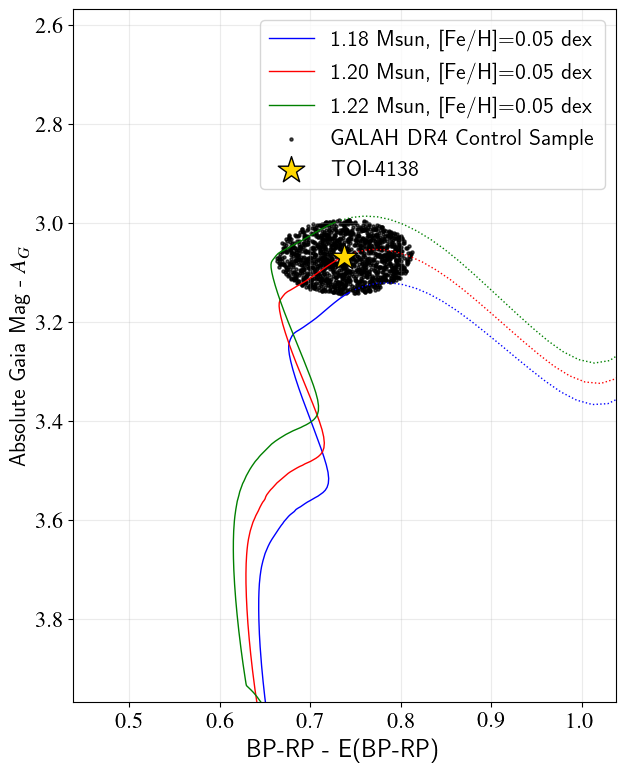

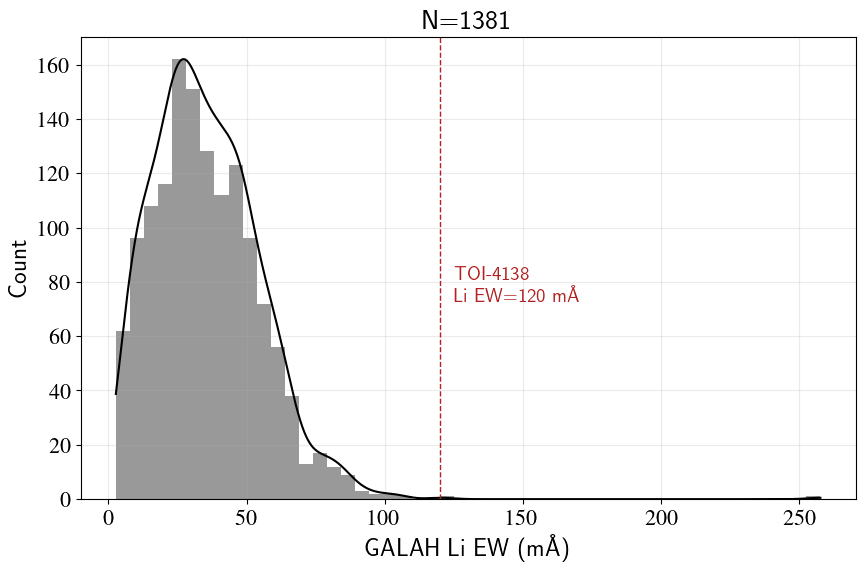

In [6]:
# galah_file = '/Users/jack/Research/meep2/galah_analysis/GALAH_DR3_main_allstar_v2.fits'
galah_file = '/Users/jack/Research/meep2/galah_analysis/galah_dr4_allstar_240705.fits'
MIST_track_path = '/Users/jack/Research/meep2/toi4138/MIST_eep_663a942a43f44'

target_df, compstars_merged = galah_analysis_LiEW('TOI-4138', 120, galah_file, MIST_track_path=MIST_track_path, AG=0.0646, E_BPRP=0.02, feh=0.05,
               teff_limits=(-np.inf, np.inf), logg_limits=(-np.inf, np.inf), feh_limits=(-np.inf, np.inf), save=True, return_dfs=True)

INFO: Query finished. [astroquery.utils.tap.core]
Duplicate columns found: ['GaiaDR3' 'bp_rp' 'dec' 'parallax' 'phot_g_mean_mag' 'ra' 'ruwe']
Reading in: /Users/jack/Research/MEEP2/toi4773/MIST_eep_663a5b1e67163/0014800M.track.eep.cmd
1.48 Msun, [Fe/H]=0.05 dex
Reading in: /Users/jack/Research/MEEP2/toi4773/MIST_eep_663a5b1e67163/0015000M.track.eep.cmd
1.50 Msun, [Fe/H]=0.05 dex
Reading in: /Users/jack/Research/MEEP2/toi4773/MIST_eep_663a5b1e67163/0015200M.track.eep.cmd
1.52 Msun, [Fe/H]=0.05 dex
Baseline Median = 11.862462
Baseline MAD = 7.555347442626953
Baseline Standard Deviation = 19.383529663085938
Target is in the 80.23% percentile of the comparison sample.
Modified z-score: 2.7887161393277453


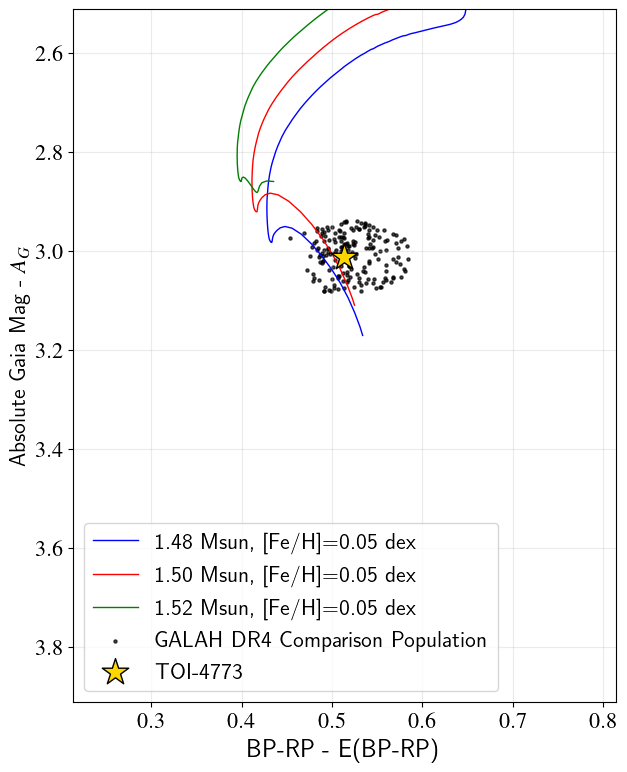

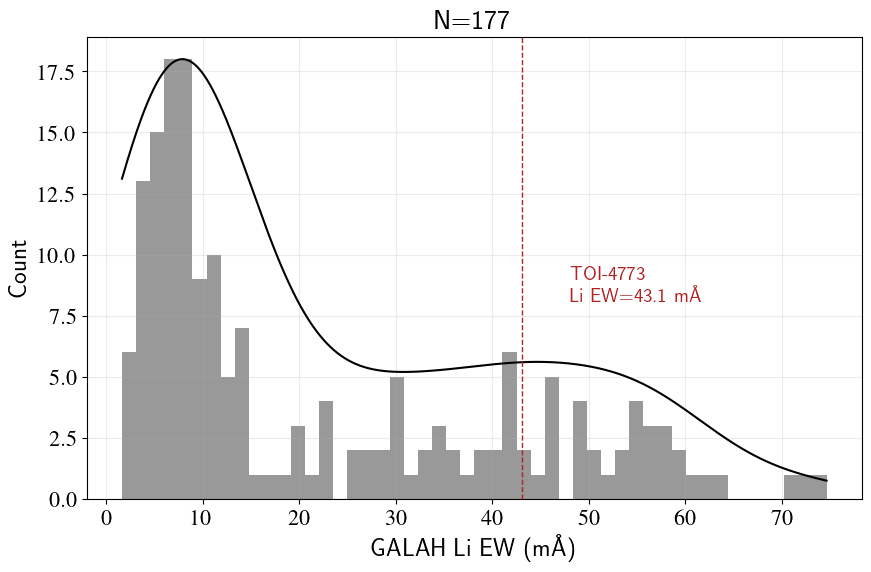

In [53]:
galah_file = '/Users/jack/Research/meep2/galah_analysis/galah_dr4_allstar_240705.fits'
MIST_track_path = '/Users/jack/Research/MEEP2/toi4773/MIST_eep_663a5b1e67163'

color_limits=(0.3, 0.7); gmag_limits=(2.8, 3.2)
target_df, comp_df = galah_analysis_LiEW('TOI-4773', 43.1, galah_file, MIST_track_path=MIST_track_path, plot_tracks=True, return_dfs=True,
                                    feh=0.05, teff_limits=(-np.inf, np.inf), logg_limits=(-np.inf, np.inf), feh_limits=(-np.inf, np.inf))

INFO: Query finished. [astroquery.utils.tap.core]
Duplicate columns found: ['GaiaDR3' 'bp_rp' 'dec' 'parallax' 'phot_g_mean_mag' 'ra' 'ruwe']
Reading in: /Users/jack/Research/MEEP2/toi5350/MIST_eep_663e7616b5fa8/0010000M.track.eep.cmd
1.00 Msun, [Fe/H]=0.0322 dex
Reading in: /Users/jack/Research/MEEP2/toi5350/MIST_eep_663e7616b5fa8/0010500M.track.eep.cmd
1.05 Msun, [Fe/H]=0.0322 dex
Reading in: /Users/jack/Research/MEEP2/toi5350/MIST_eep_663e7616b5fa8/0011000M.track.eep.cmd
1.10 Msun, [Fe/H]=0.0322 dex
Baseline Median = 35.993908
Baseline MAD = 8.22536563873291
Baseline Standard Deviation = 15.996310234069824
Target is in the 68.30% percentile of the comparison sample.
Modified z-score: 0.41871197628360896


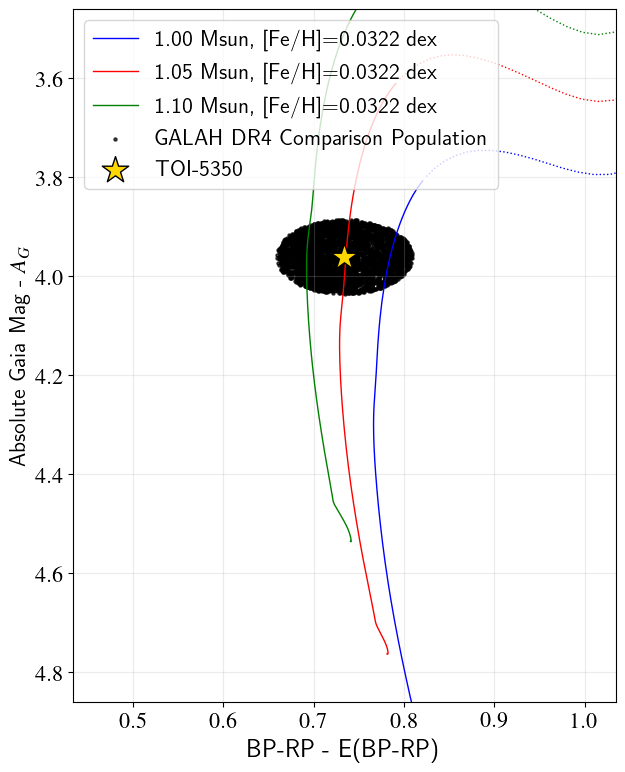

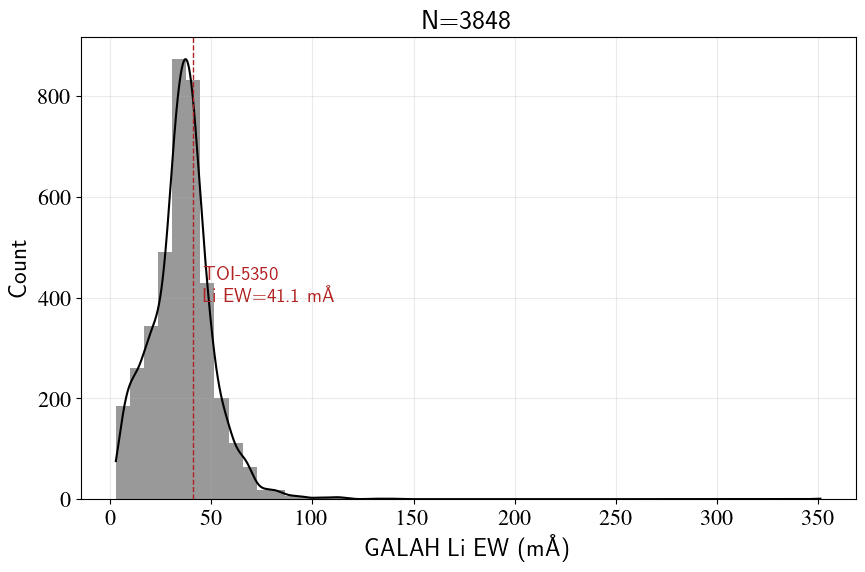

In [54]:
galah_file = '/Users/jack/Research/meep2/galah_analysis/galah_dr4_allstar_240705.fits'
MIST_track_path = '/Users/jack/Research/MEEP2/toi5350/MIST_eep_663e7616b5fa8'

target_df, comp_df = galah_analysis_LiEW('TOI-5350', 41.1, galah_file, MIST_track_path=MIST_track_path, plot_tracks=True, return_dfs=True,
                                    feh=0.0322, teff_limits=(-np.inf, np.inf), logg_limits=(-np.inf, np.inf), feh_limits=(-np.inf, np.inf))

INFO: Query finished. [astroquery.utils.tap.core]
Duplicate columns found: ['GaiaDR3' 'bp_rp' 'dec' 'parallax' 'phot_g_mean_mag' 'ra' 'ruwe']
Reading in: /Users/jack/Research/MEEP2/toi6420/MIST_eep_663bacf723908/0011000M.track.eep.cmd
1.10 Msun, [Fe/H]=0.2513 dex
Reading in: /Users/jack/Research/MEEP2/toi6420/MIST_eep_663bacf723908/0011500M.track.eep.cmd
1.15 Msun, [Fe/H]=0.2513 dex
Reading in: /Users/jack/Research/MEEP2/toi6420/MIST_eep_663bacf723908/0012000M.track.eep.cmd
1.20 Msun, [Fe/H]=0.2513 dex
Baseline Median = 34.610645
Baseline MAD = 9.327220916748047
Baseline Standard Deviation = 16.33681869506836
Target is in the 82.67% percentile of the comparison sample.
Modified z-score: 0.8091606081204051


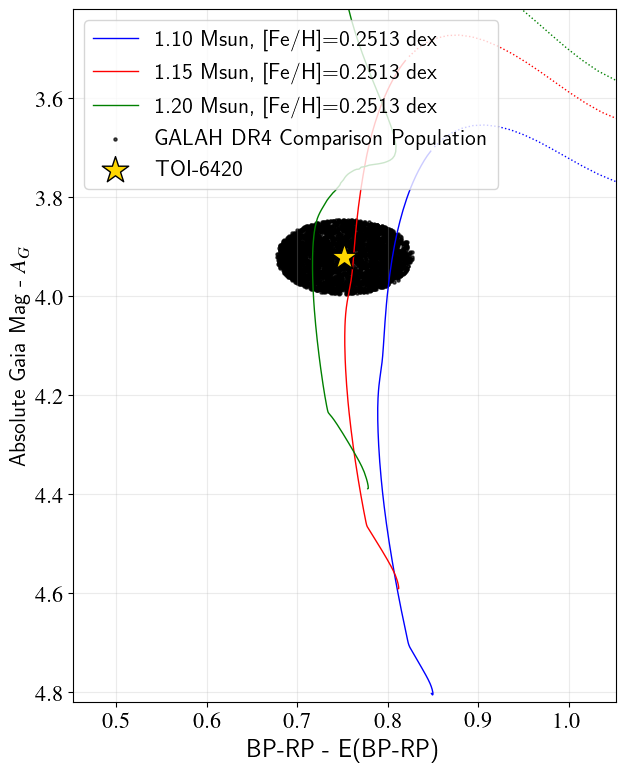

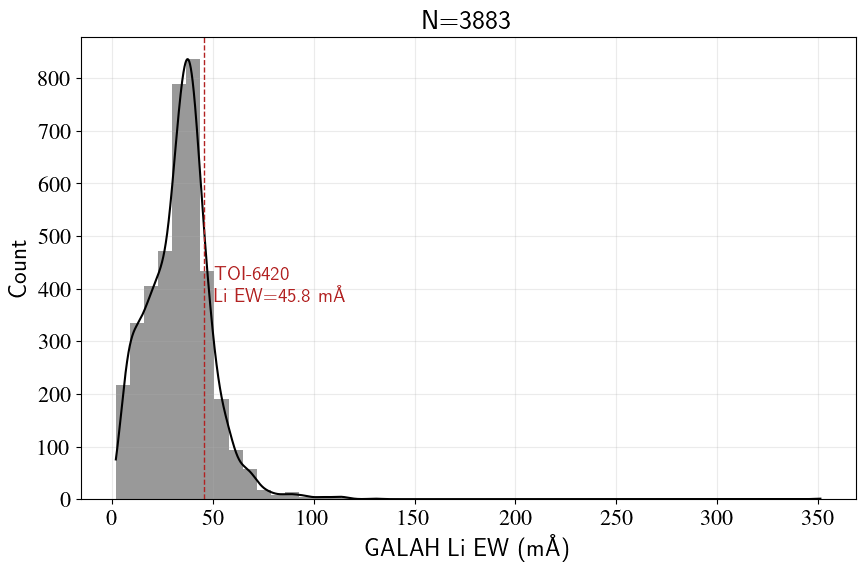

In [55]:
galah_file = '/Users/jack/Research/meep2/galah_analysis/galah_dr4_allstar_240705.fits'
MIST_track_path = '/Users/jack/Research/MEEP2/toi6420/MIST_eep_663bacf723908'

target_df, comp_df = galah_analysis_LiEW('TOI-6420', 45.8, galah_file, MIST_track_path=MIST_track_path, plot_tracks=True, return_dfs=True,
                                    feh=0.2513, teff_limits=(-np.inf, np.inf), logg_limits=(-np.inf, np.inf), feh_limits=(-np.inf, np.inf))

In [10]:
def galah_analysis(targetid, target_ALi, galah_file, color_limits='default', gmag_limits='default', teff_limits='default', logg_limits='default', 
                   feh_limits='default', target_common_name=None, teff=None, logg=None, feh=None, AG=None, E_BPRP=None, plot_tracks=True, MIST_track_path=None, 
                   cmd_xlim = None, cmd_ylim = None, save=False, return_dfs=False):
    '''
    Build a comparison sample from GALAH and Gaia and measure the significance of a target's A(Li) measurement.

    targetid: The target's TOI number or TIC ID, to be used to query Gaia. E.g. 'TOI-3129' or 'TIC 4711'
    target_ALi: The target's measured A(Li) in dex.
    galah_file: The path to GALAH data file.

    Optional Inputs
    ---------------
    target_common_name: The star's common name (if you wish the name on the plots to be different from the provided targetid).
    teff: The target's effective temperature in Kelvin.
    logg: The target's logg in cgs units.
    color_limits: Limits on the sample's extinction-corrected BP-RP color. E.g. (0.70, 0.78). Default: target's color +/- 0.04
    gmag_limits: Limits on the sample's extinction-corrected absolute G magnitude. E.g. (3.0, 3.14). Default: target's G +/- 0.07
    teff_limits: Limits on the sample's effective temperature in Kelvin. E.g. (5800, 6200). Default: target's Teff +/- 200 K.
    logg_limits: Limits on the sample's logg in cgs. E.g. (3.9, 4.1). Default: target's logg +/- 0.1.
    feh_limits: Limits on the sample's metallicity ([Fe/H]). E.g. (0.0, 0.1). Default: target's [Fe/H] +/- 0.05.
    AG: The target's extinction in the Gaia G bandpass.
    E_BPRP: The target's extinction in Gaia BP - RP color.
    plot_tracks: A boolean to decide whether or not to plot the MIST tracks.
    MIST_track_path: If plot_tracks is True, this should be a string containing the path to the MIST files.
    cmd_xlim: Manually set x-limits for the CMD plot. Should be a tuple: (lower_limit, upper_limit)
    cmd_ylim: Manually set y-limits for the CMD plot. Should be a tuple: (lower_limit, upper_limit)
    save: A boolean to decide whether or not the figures should be saved.
    return_dfs: Whether or not to return the target and comparison sample DataFrames.
    '''
    
    target_df = grab_target_gaia_data(targetid=targetid, teff=teff, logg=logg, AG=AG, E_BPRP=E_BPRP, feh=feh)

    compstars_gaia = query_and_cut_gaia(color_limits=color_limits, gmag_limits=gmag_limits, target_df=target_df)
    compstars_galah = grab_and_cut_galah(file=galah_file, teff_limits=teff_limits, logg_limits=logg_limits, feh_limits=feh_limits, target_df=target_df)
    compstars_merged = merge_and_compute(gaia_df=compstars_gaia, galah_df=compstars_galah)

    if target_common_name == None:
        target_common_name = targetid
    plot_sample(target_name=target_common_name, target_df=target_df, target_ALi=target_ALi, compstars_df=compstars_merged, plot_tracks=plot_tracks, 
                MIST_track_path=MIST_track_path, cmd_xlim=cmd_xlim, cmd_ylim=cmd_ylim, save=save)
    
    compute_significance(compstars_df=compstars_merged, target_ALi=target_ALi)

    if return_dfs==True:
        return target_df, compstars_merged

## Testing

In [ ]:
grab_and_cut_galah(file, 'default', 'default', 'default', target_df=None)

INFO: Query finished. [astroquery.utils.tap.core]
Duplicate columns found: ['GaiaDR3' 'bp_rp' 'dec' 'parallax' 'phot_g_mean_mag' 'ra' 'ruwe']
Reading in: /Users/jack/Research/meep2/toi4138/MIST_eep_663a942a43f44/0011800M.track.eep.cmd
1.18 Msun, [Fe/H]=0.05 dex
Reading in: /Users/jack/Research/meep2/toi4138/MIST_eep_663a942a43f44/0012000M.track.eep.cmd
1.20 Msun, [Fe/H]=0.05 dex
Reading in: /Users/jack/Research/meep2/toi4138/MIST_eep_663a942a43f44/0012200M.track.eep.cmd
1.22 Msun, [Fe/H]=0.05 dex
Baseline Median = 2.1745698
Baseline MAD = 0.19278168678283691
Baseline Standard Deviation = 0.3181234300136566
Significance: 3.5025149887173264 * sigma
Modified z-score: 1.5934482395048135


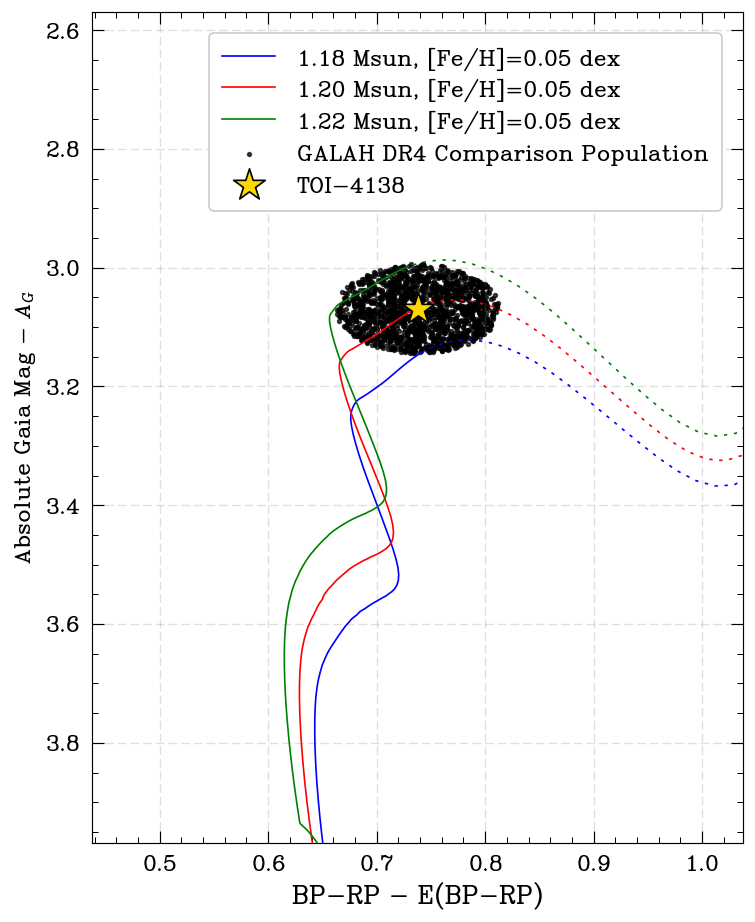

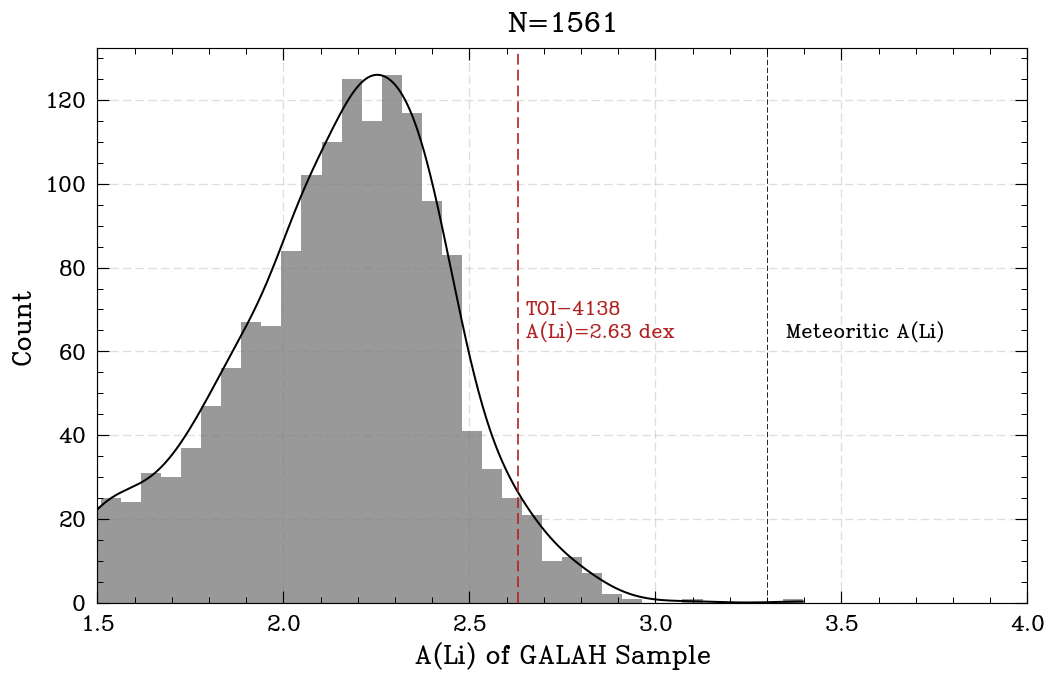

In [11]:
# galah_file = '/Users/jack/Research/meep2/galah_analysis/GALAH_DR3_main_allstar_v2.fits'
galah_file = '/Users/jack/Research/meep2/galah_analysis/galah_dr4_allstar_240705.fits'
MIST_track_path = '/Users/jack/Research/meep2/toi4138/MIST_eep_663a942a43f44'

galah_analysis('TOI-4138', 2.63, galah_file, MIST_track_path=MIST_track_path, AG=0.0646, E_BPRP=0.02, feh=0.05,
               teff_limits=(-np.inf, np.inf), logg_limits=(-np.inf, np.inf), feh_limits=(-np.inf, np.inf), save=True)

INFO: Query finished. [astroquery.utils.tap.core]
Duplicate columns found: ['GaiaDR3' 'bp_rp' 'dec' 'parallax' 'phot_g_mean_mag' 'ra' 'ruwe']
Reading in: /Users/jack/Research/MEEP2/toi4773/MIST_eep_663a5b1e67163/0014800M.track.eep.cmd
1.48 Msun, [Fe/H]=0.05 dex
Reading in: /Users/jack/Research/MEEP2/toi4773/MIST_eep_663a5b1e67163/0015000M.track.eep.cmd
1.50 Msun, [Fe/H]=0.05 dex
Reading in: /Users/jack/Research/MEEP2/toi4773/MIST_eep_663a5b1e67163/0015200M.track.eep.cmd
1.52 Msun, [Fe/H]=0.05 dex
Baseline Median = 2.201875
Baseline MAD = 0.4048166275024414
Baseline Standard Deviation = 0.4961514472961426
Significance: 2.1173245098791225 * sigma
Modified z-score: 0.9632641183822123


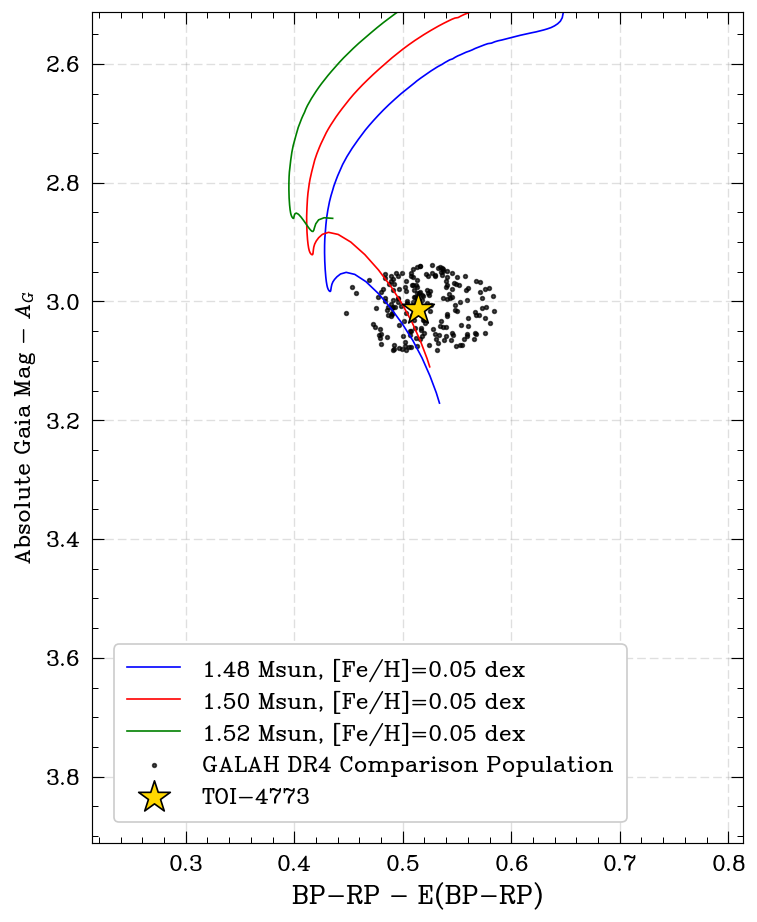

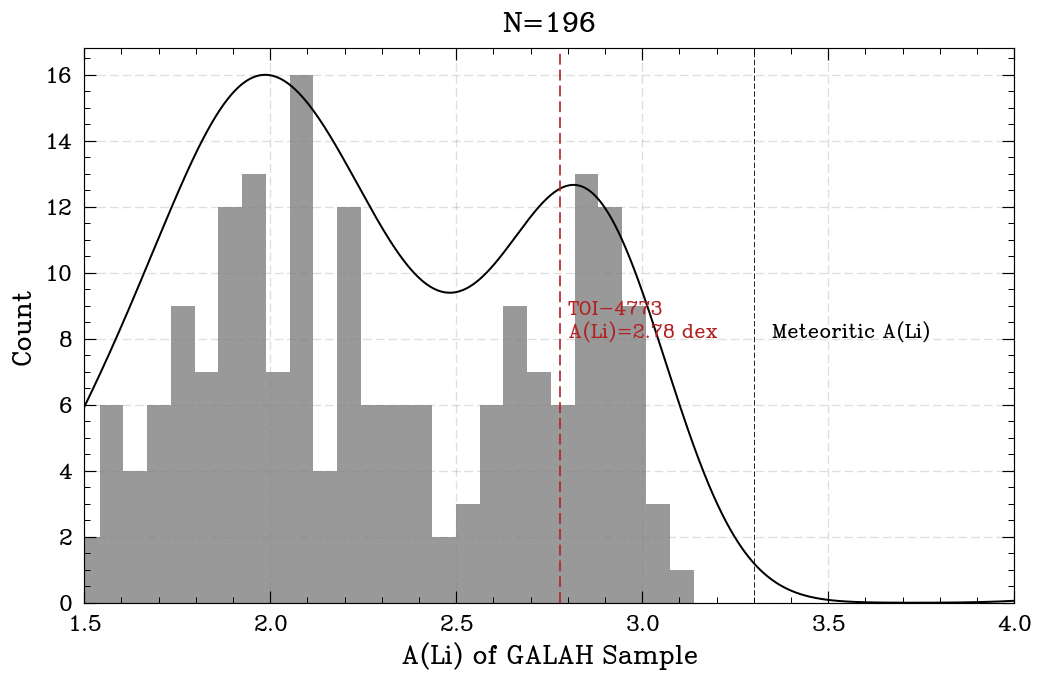

In [12]:
galah_file = '/Users/jack/Research/meep2/galah_analysis/galah_dr4_allstar_240705.fits'
MIST_track_path = '/Users/jack/Research/MEEP2/toi4773/MIST_eep_663a5b1e67163'

color_limits=(0.3, 0.7); gmag_limits=(2.8, 3.2); teff_limits=(6890 - 2000, 6890 + 2000); logg_limits=(4.23 - 1, 4.23 + 1); feh_limits=(-1, 1)
target_df, comp_df = galah_analysis('TOI-4773', 2.78, galah_file, MIST_track_path=MIST_track_path, plot_tracks=True, return_dfs=True,
                                    feh=0.05, color_limits=color_limits, gmag_limits=gmag_limits, teff_limits=teff_limits, logg_limits=logg_limits,
                                    feh_limits=feh_limits)

INFO: Query finished. [astroquery.utils.tap.core]
Duplicate columns found: ['GaiaDR3' 'bp_rp' 'dec' 'parallax' 'phot_g_mean_mag' 'ra' 'ruwe']
Reading in: /Users/jack/Research/MEEP2/toi5350/MIST_eep_663e7616b5fa8/0010000M.track.eep.cmd
1.00 Msun, [Fe/H]=0.0322 dex
Reading in: /Users/jack/Research/MEEP2/toi5350/MIST_eep_663e7616b5fa8/0010500M.track.eep.cmd
1.05 Msun, [Fe/H]=0.0322 dex
Reading in: /Users/jack/Research/MEEP2/toi5350/MIST_eep_663e7616b5fa8/0011000M.track.eep.cmd
1.10 Msun, [Fe/H]=0.0322 dex
Baseline Median = 2.2379646
Baseline MAD = 0.14329755306243896
Baseline Standard Deviation = 0.2985750734806061
Significance: 0.7452998121136348 * sigma
Modified z-score: 0.3390696905912901


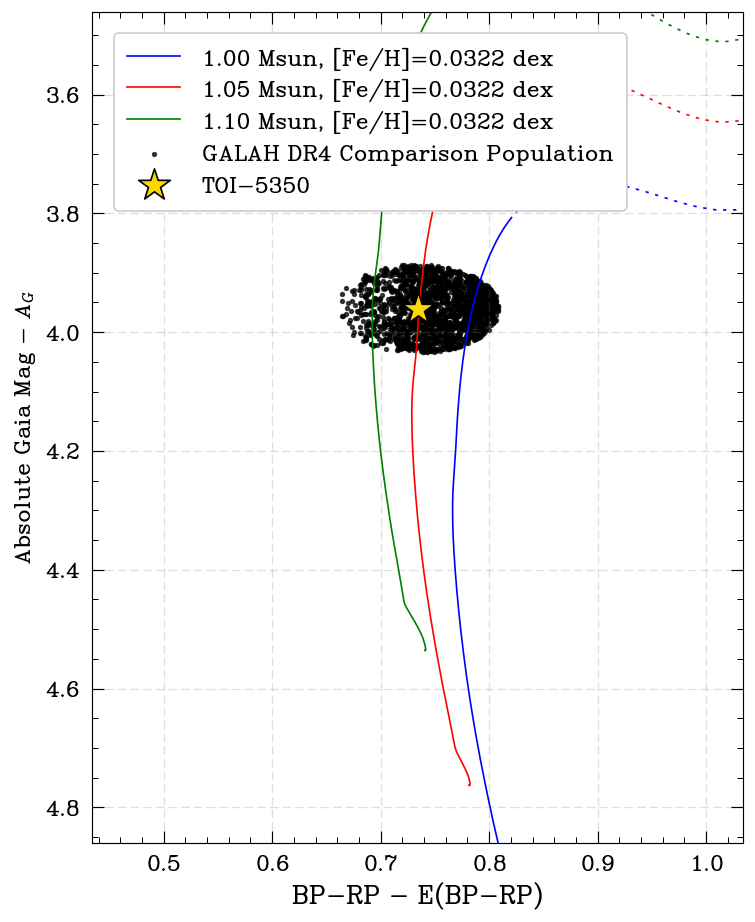

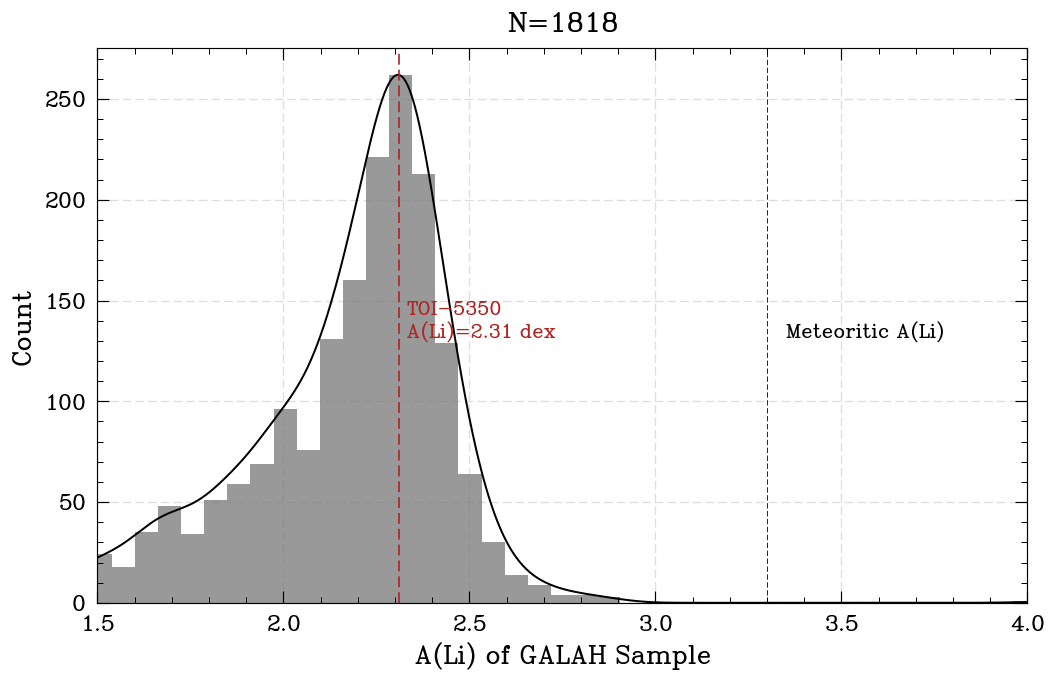

In [13]:
galah_file = '/Users/jack/Research/meep2/galah_analysis/galah_dr4_allstar_240705.fits'
MIST_track_path = '/Users/jack/Research/MEEP2/toi5350/MIST_eep_663e7616b5fa8'

target_df, comp_df = galah_analysis('TOI-5350', 2.31, galah_file, MIST_track_path=MIST_track_path, plot_tracks=True, return_dfs=True,
                                    feh=0.0322, feh_limits=(-0.2, 0.2))

INFO: Query finished. [astroquery.utils.tap.core]
Duplicate columns found: ['GaiaDR3' 'bp_rp' 'dec' 'parallax' 'phot_g_mean_mag' 'ra' 'ruwe']
Reading in: /Users/jack/Research/MEEP2/toi6420/MIST_eep_663bacf723908/0011000M.track.eep.cmd
1.10 Msun, [Fe/H]=0.2513 dex
Reading in: /Users/jack/Research/MEEP2/toi6420/MIST_eep_663bacf723908/0011500M.track.eep.cmd
1.15 Msun, [Fe/H]=0.2513 dex
Reading in: /Users/jack/Research/MEEP2/toi6420/MIST_eep_663bacf723908/0012000M.track.eep.cmd
1.20 Msun, [Fe/H]=0.2513 dex
Baseline Median = 2.2983246
Baseline MAD = 0.14336764812469482
Baseline Standard Deviation = 0.2804967164993286
Significance: -0.6031488330468816 * sigma
Modified z-score: -0.27439895311622936


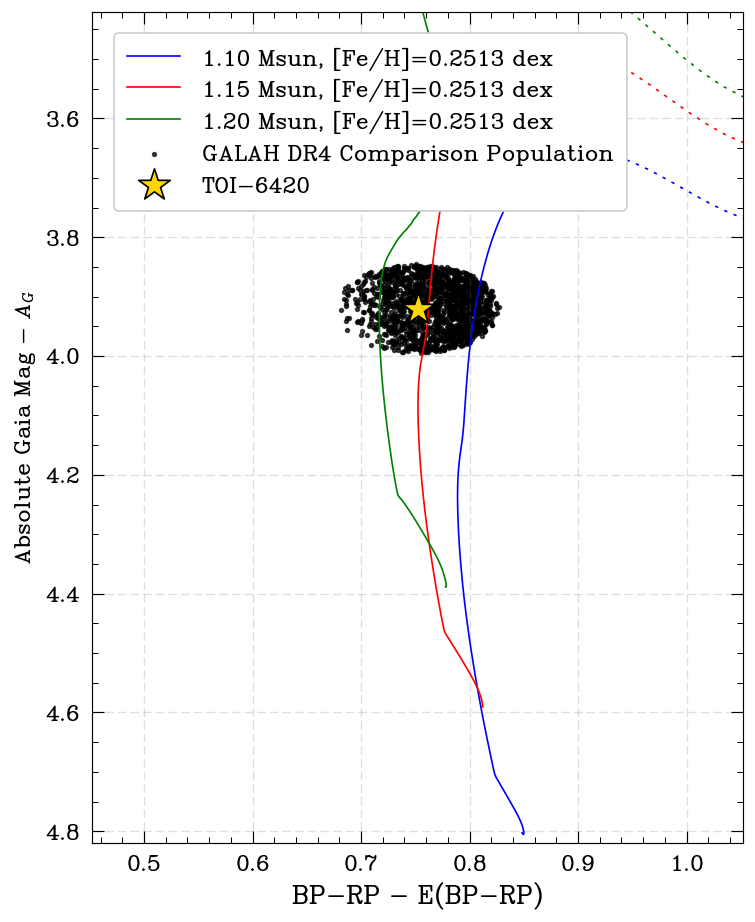

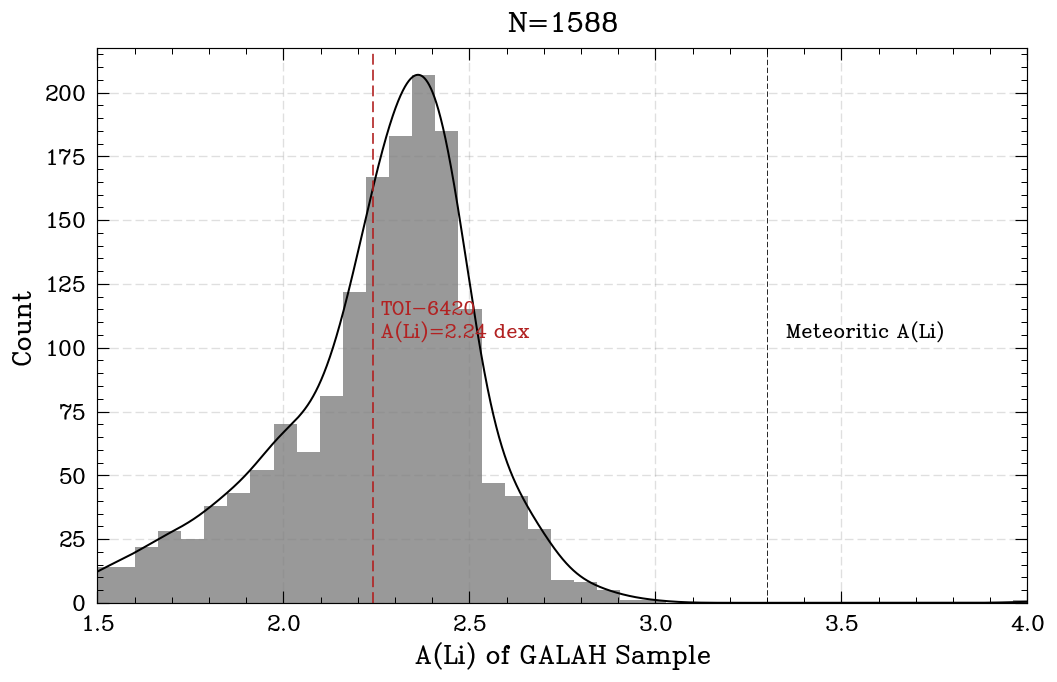

In [14]:
galah_file = '/Users/jack/Research/meep2/galah_analysis/galah_dr4_allstar_240705.fits'
MIST_track_path = '/Users/jack/Research/MEEP2/toi6420/MIST_eep_663bacf723908'

target_df, comp_df = galah_analysis('TOI-6420', 2.24, galah_file, MIST_track_path=MIST_track_path, plot_tracks=True, return_dfs=True,
                                    feh=0.2513, feh_limits=(0, 0.4))